In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
folder = 'drive/MyDrive/Colab Notebooks/uncertainty'

In [4]:
%cd '{folder}'
%pwd

/content/drive/MyDrive/Colab Notebooks/uncertainty


'/content/drive/MyDrive/Colab Notebooks/uncertainty'

In [5]:
%ls

data/  model/  scripts/  train.ipynb  utils/  weights/


## Prepare environement

In [6]:
!pip install libpysal torch_geometric geopandas torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 60.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 41.0 MB/s eta 0:00:00
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=f256043004efac340aa047ff8a5ef7c96298cc2add729dc1c19cc1dc8b6ade43
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


## Training

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from utils.prepare_data import prepare_input
from utils.class_loss import MVELoss
from utils.evaluate import evaluate
from model.class_GCN import GCN_LSTM

%load_ext autoreload
%autoreload 2

In [8]:
# Define hyperparameters
n_features = 2
n_stations = 63
hid_g = 64
hid_fc = 64
hid_l = 64
meanonly = False
homo = 0
batch_size = 32
learning_rate = 0.0001
weight_decay = 0.001
dropout = 0.2
num_epochs = 20
nadj = ['euc','con','func']
dist = 'norm'
z = 0.95

# Define other parameters
SAVEPATH = "./weights/model_norm.pt"
filepath = 'data/processed/0620.npz'
adjfile = 'data/processed/adjlist.csv'

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

# Create the network
net = GCN_LSTM(n_features,n_stations,hid_g,hid_fc,hid_l,meanonly,homo,nadj,device,dropout)
net = net.to(device)

# Define the loss function
loss_fn = MVELoss(dist)

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Read in and prepare dataset
data = data = np.load(filepath)
x = data['x']
y = data['y']
adj = pd.read_csv(adjfile)
history = data['history']
weather = data['weather']
los = data['los']

train_loader,val_loader,test_loader,adj_torch = prepare_input(x,y,adj,nadj,history,weather,los,device,batch_size=batch_size)
train_num = len(train_loader.dataset)
eval_num = len(val_loader.dataset)
batch_number = len(train_loader)

In [52]:
print('Start training ...')
print(f"Training sample:{train_num}")

# Training loop
loss_history = []
loss_eval = []
for epoch in range(1,num_epochs+1):

    running_loss = 0.0

    # Iterate over the batches
    for i,traindata in enumerate(train_loader,1):

        net.train()

        batch_x, batch_y, batch_history, batch_weather, batch_los = traindata

        batch_x = batch_x.float()
        batch_y = torch.squeeze(batch_y).float()
        batch_history = batch_history.float()

        batch_x, batch_y, batch_history, batch_weather, batch_los = \
                batch_x.to(device), batch_y.to(device), batch_history.to(device), \
                batch_weather.to(device), batch_los.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = net(batch_x, adj_torch, batch_history, batch_weather, batch_los, device)

        # Compute the loss
        if outputs.shape[0]!=2*batch_size:
            batch_new = int((outputs.shape[0])/2)
            output_loc = outputs[:batch_new,:]
            output_scale = outputs[batch_new:,:]
        else:
            output_loc = outputs[:batch_size,:]
            output_scale = outputs[batch_size:,:]
        loss = loss_fn(output_loc, output_scale, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # if i%20 == 0:
        #   print('Ep:', epoch, 'Batch:', i, 'Loss:', loss)
        running_loss += loss.item()

    # Print the average loss for the epoch and evaluate
    loss_history.append(running_loss/train_num)

    ################ Evaluate ###############
    net.eval()

    eval_loss = 0

    for j,evaldata in enumerate(val_loader):
        batch_x, batch_y, batch_history, batch_weather, batch_los = evaldata

        batch_x = batch_x.float()
        batch_y = torch.squeeze(batch_y).float()
        batch_history = batch_history.float()

        batch_x, batch_y, batch_history, batch_weather, batch_los = \
            batch_x.to(device), batch_y.to(device), batch_history.to(device), \
            batch_weather.to(device), batch_los.to(device)

        outputs = net(batch_x, adj_torch, batch_history, batch_weather, batch_los, device)
        if outputs.shape[0]!=2*batch_size:
            batch_new = int((outputs.shape[0])/2)
            output_loc = outputs[:batch_new,:]
            output_scale = outputs[batch_new:,:]
        else:
            output_loc = outputs[:batch_size,:]
            output_scale = outputs[batch_size:,:]

        loss = loss_fn(output_loc, output_scale, batch_y)
        eval_loss += loss.item()

    loss_eval.append(eval_loss/eval_num)

    # Save best model
    if epoch == 1:
        loss_best = eval_loss
    else:
        if eval_loss < loss_best:
            loss_best = eval_loss
            torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss history': loss_history,
            'average eval batch loss': eval_loss/eval_num,
            }, SAVEPATH)

    print('Ep:', epoch, '| Average loss;', running_loss/train_num, '| Evaluation loss:',eval_loss/eval_num)

Start training ...
Training sample:4595
Ep: 1 | Average loss; 855.6201463037269 | Evaluation loss: 511.79415627722125
Ep: 2 | Average loss; 356.51826724445726 | Evaluation loss: 287.34572439160496
Ep: 3 | Average loss; 265.23060009181177 | Evaluation loss: 243.21858326981706
Ep: 4 | Average loss; 234.18376387802638 | Evaluation loss: 223.4578042910905
Ep: 5 | Average loss; 221.3419800734494 | Evaluation loss: 215.15284521654507
Ep: 6 | Average loss; 215.44127947752312 | Evaluation loss: 209.15722900815956
Ep: 7 | Average loss; 209.00068683478986 | Evaluation loss: 201.2167681119168
Ep: 8 | Average loss; 201.64027518022306 | Evaluation loss: 193.21771779874476
Ep: 9 | Average loss; 192.6535088241295 | Evaluation loss: 181.0236494217185
Ep: 10 | Average loss; 175.4859623656828 | Evaluation loss: 151.3691380730074
Ep: 11 | Average loss; 154.59309871038494 | Evaluation loss: 138.387177045337
Ep: 12 | Average loss; 148.12898610709672 | Evaluation loss: 135.97981799188807
Ep: 13 | Average lo

In [59]:
print('Testing ...')
z = 0.95
loss, mae, mape, mpiw, picp = evaluate(net, loss_fn, adj_torch, dist, test_loader, z, device, batch_size)
print('Average loss;', loss, '| MAE:',mae, '| MAPE:',mape, '| MPIW',mpiw, '| PICP:',picp)

Testing ...
Average loss; 153.24218505859375 | MAE: 4.609720230102539 | MAPE: 0.3648771345615387 | MPIW 3.7434878688477664e+17 | PICP: 0.9096204278812975


(120.0, 200.0)

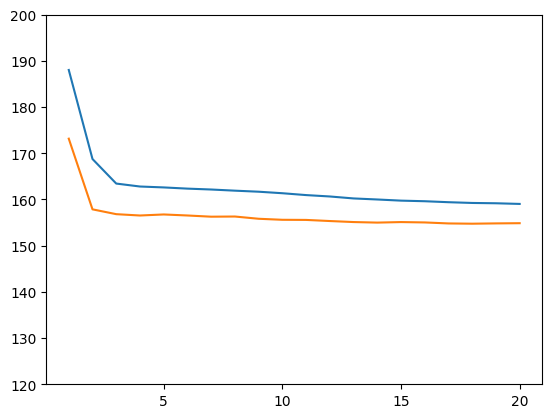

In [ ]:
# Visualize result
plt.plot(range(1,num_epochs+1),loss_history,label='train')
plt.plot(range(1,num_epochs+1),loss_eval,label='validate')
plt.xticks([5,10,15,20])
plt.ylim([120,200])

## Load model

In [10]:
SAVEPATH = 'weights/model_norm.pt'
checkpoint = torch.load(SAVEPATH)
trained_model = GCN_LSTM(n_features,n_stations,hid_g,hid_fc,hid_l,meanonly,homo,nadj,device,dropout)
trained_model.load_state_dict(checkpoint['model_state_dict'])
trained_model.to(device)

GCN_LSTM(
  (batchnorm): BatchNorm1d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcn): GCNLayer(
    (gc1): GCNConv(2, 64)
    (gc2): GCNConv(64, 64)
  )
  (fc1): Linear(in_features=4032, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (lstm): LSTM(64, 64)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (final): Linear(in_features=64, out_features=126, bias=True)
  (recent_on_history_mean): Linear(in_features=64, out_features=63, bias=True)
  (recent_on_history_var): Linear(in_features=64, out_features=63, bias=True)
)

In [11]:
net.eval()
eval_loss = 0
eval_num = len(test_loader.dataset)
for i,evaldata in enumerate(test_loader):
    batch_x, batch_y, batch_history, batch_weather, batch_los = evaldata

    batch_x = batch_x.float()
    batch_y = torch.squeeze(batch_y).float()
    batch_history = batch_history.float()

    batch_x, batch_y, batch_history, batch_weather, batch_los = \
        batch_x.to(device), batch_y.to(device), batch_history.to(device), \
        batch_weather.to(device), batch_los.to(device)

    outputs = net(batch_x, adj_torch, batch_history, batch_weather, batch_los, device)
    if outputs.shape[0]!=2*batch_size:
        batch_new = int((outputs.shape[0])/2)
        output_loc = outputs[:batch_new,:]
        output_scale = outputs[batch_new:,:]
    else:
        output_loc = outputs[:batch_size,:]
        output_scale = outputs[batch_size:,:]
    loss = loss_fn(output_loc, output_scale, batch_y)

    loss = loss_fn(output_loc, output_scale, batch_y)
    eval_loss += loss.item()

    # Get mean and variance
    if i == 0:
        test_out_mean = outputs[:batch_size,:].cpu().detach().numpy()
        test_out_var = outputs[batch_size:,:].cpu().detach().numpy()
        y_eval = batch_y.cpu().numpy()
    else:
        if outputs.shape[0]==2*batch_size:
            test_out_mean = np.concatenate((test_out_mean, outputs[:batch_size,:].cpu().detach().numpy()), axis=0)
            test_out_var = np.concatenate((test_out_var, outputs[batch_size:,:].cpu().detach().numpy()), axis=0)
            y_eval = np.concatenate((y_eval, batch_y.cpu().numpy()), axis=0)
        else:
            batch_new = int((outputs.shape[0])/2)
            test_out_mean = np.concatenate((test_out_mean, outputs[:batch_new,:].cpu().detach().numpy()), axis=0)
            test_out_var = np.concatenate((test_out_var, outputs[batch_new:,:].cpu().detach().numpy()), axis=0)
            y_eval = np.concatenate((y_eval, batch_y.cpu().numpy()), axis=0)

In [12]:
test_out_mean[0]

array([ 2.309688  ,  0.7340407 ,  2.6885543 ,  1.4911637 ,  4.9411516 ,
        5.962687  ,  1.2967938 ,  1.626697  ,  9.529824  ,  4.3138924 ,
        7.7638135 ,  3.6080668 ,  4.218843  , 13.369607  ,  3.6736143 ,
        1.8992916 ,  4.529403  ,  4.7650113 ,  6.4970436 ,  4.5949945 ,
        6.839124  ,  2.790973  ,  0.7992519 ,  2.1928585 ,  1.9780228 ,
        0.88160586,  3.8376842 ,  3.273751  ,  3.292949  ,  4.121777  ,
        2.4403942 ,  4.206831  ,  8.932828  ,  2.0156307 ,  2.0473194 ,
        5.4844093 , 13.475431  ,  6.610508  ,  6.5132666 ,  6.959594  ,
        3.0873196 ,  6.71276   ,  4.2302313 ,  1.6444232 ,  3.3173075 ,
        1.1121329 ,  3.4518015 , 13.260543  ,  7.901392  ,  3.1750817 ,
        2.8750608 , 10.367644  ,  3.3287656 ,  4.6572075 ,  3.8919318 ,
        5.717101  ,  3.0768719 ,  5.371275  ,  6.5792027 ,  9.06125   ,
        1.7489941 ,  1.9392844 ,  3.2540307 ], dtype=float32)

In [13]:
test_out_var[0]

array([ 2.3308578 ,  0.72080785,  2.6912742 ,  1.4490339 ,  4.8370085 ,
        6.383208  ,  1.2406455 ,  1.5511298 ,  9.1199255 ,  4.3816414 ,
        7.8631153 ,  3.6701384 ,  3.826976  , 13.054746  ,  3.6946096 ,
        1.8897206 ,  4.7837667 ,  4.99961   ,  5.834854  ,  4.4589767 ,
        6.7444835 ,  2.8239634 ,  0.7712037 ,  2.3377125 ,  2.1081505 ,
        0.851064  ,  4.0237613 ,  3.082076  ,  3.2762744 ,  4.4540095 ,
        2.379205  ,  4.1645412 ,  9.187275  ,  2.1717205 ,  2.212412  ,
        5.4144826 , 15.088587  ,  6.4376655 ,  6.4678373 ,  7.429518  ,
        3.1637583 ,  6.191469  ,  4.130323  ,  1.8015553 ,  3.541147  ,
        1.2668896 ,  3.4489582 , 13.537663  ,  8.368893  ,  3.2257376 ,
        2.6970916 , 10.526032  ,  3.517399  ,  4.5470133 ,  4.33051   ,
        5.2790694 ,  2.8484755 ,  4.9401927 ,  6.596887  ,  8.747095  ,
        1.8925112 ,  1.827001  ,  2.9996653 ], dtype=float32)

In [14]:
print('Testing ...')
loss, mae, mape, mpiw, picp = evaluate(trained_model, loss_fn, adj_torch, dist, test_loader, z, device, batch_size)
print('Average loss;', loss, '| MAE:',mae, '| MAPE:',mape, '| MPIW',mpiw, '| PICP:',picp)

Testing ...
Average loss; 168.27926842730977 | MAE: 3.11531400680542 | MAPE: 0.24658912420272827 | MPIW 14.558016368870721 | PICP: 0.9251621808143548
